## Hierarchical RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torchsummary import summary

import time
import os, glob
import cv2
import copy
from os.path import join, isdir
import random

print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.0.1.post2


In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import sys  
sys.path.append('/home/wei-chan.hsu/Dokumente/Lameness-Detection/utils')  
from auxiliaryfunctions import classify, tag_loc, copy_files

## Data preprocessing

### Split data

In [14]:
# Shuffle dataset
datadir = '/home/wei-chan.hsu/Dokumente/Thesis/src/annotation/data/all2/data_json/'
all_files = os.listdir(os.path.abspath(datadir))
data_files = list(filter(lambda file: file.endswith('.json'), all_files))

print("Before shuffle: ", data_files[:5])
random.shuffle(data_files)
print("After shuffle: ", data_files[:5])

Before shuffle:  ['cow239-3.json', 'cow1-14.json', 'cow1407-6.json', 'cow1407-1.json', 'cow161-0.json']
After shuffle:  ['cow155-3.json', 'cow284-1.json', 'cow202-14.json', 'cow181-4.json', 'cow181-7.json']


In [16]:
# Split data into two sets
split_ratio = 0.8
split_tt = int(split_ratio * len(data_files))
training_set = data_files[:split_tt]
test_set = data_files[split_tt:]
split_tv = int(split_ratio * len(training_set))
val_set = training_set[split_tv:]
training_set = training_set = data_files[:split_tt][:split_tv]


print("Training set ({} samples): ".format(len(training_set)), training_set[:5])
print("Validation set ({} samples): ".format(len(val_set)), val_set[:5])
print("Test set ({} samples): ".format(len(test_set)), test_set[:5])

Training set (320 samples):  ['cow155-3.json', 'cow284-1.json', 'cow202-14.json', 'cow181-4.json', 'cow181-7.json']
Validation set (80 samples):  ['cow160-7.json', 'cow287-5.json', 'cow204-1.json', 'cow234-3.json', 'cow285-6.json']
Test set (101 samples):  ['cow253-3.json', 'cow257-6.json', 'cow191-3.json', 'cow285-1.json', 'cow234-7.json']


In [18]:
# Copy png files into directories 
src_train = [(datadir + file) for file in training_set]
src_val = [(datadir + file) for file in val_set]
src_test = [(datadir + file) for file in test_set]
dst_train = '/home/wei-chan.hsu/Dokumente/Thesis/src/lstm/data/train/'
dst_val = '/home/wei-chan.hsu/Dokumente/Thesis/src/lstm/data/val/'
dst_test = '/home/wei-chan.hsu/Dokumente/Thesis/src/lstm/data/test/'

copy_files(src_train, dst_train)
copy_files(src_val, dst_val)
copy_files(src_test, dst_test)

### Dataset and dataloader

In [4]:
class SkeletonDataset(Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_dir, csv_file):
        super(SkeletonDataset, self).__init__()
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.files = glob.glob(os.path.join(data_dir, '*.json'))
        self.label_table = pd.read_csv(csv_file)
        self.classes = [0,1,2,3]       
        self.num_sequences = 20

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        poses = []
        cow = os.path.basename(self.files[index]).split('.')[0]
        cow_id = cow.split('-')[0]
        tag = cow.split('-')[1]
        label = classify(self.label_table[(self.label_table['cow_id'] == cow_id)].iloc[0, tag_loc(int(tag))]) - 1
        
        #'''
        with open(self.files[index]) as json_file:  
            data = json.load(json_file)
            for frame in data['data']:
                num_frame = frame['frame_index'] - 1
                skeleton = frame['skeleton'][0]
                pose = np.array(skeleton['pose'])
                x_channel = pose[0::2]
                y_channel = pose[1::2]
                if num_frame < self.num_sequences:
                    poses.append(pose)
                
        #'''
        poses = np.array(poses)
        sample = {'seq': poses, 'label': label}
             
        return cow, sample


In [5]:
data_dir = '/home/wei-chan.hsu/Dokumente/Thesis/src/annotation/data/all2/data_json/'
csv_file = '/home/wei-chan.hsu/Dokumente/Thesis/src/annotation/data_labels.csv'
exset = SkeletonDataset(data_dir, csv_file)

print(len(exset))
for cow, sample in exset:
    print('{} with LS: {}'.format(cow, sample['label']))
    #print(len(sample['seq']))


501
cow239-3 with LS: 0
cow1-14 with LS: 3
cow1407-6 with LS: 1
cow1407-1 with LS: 1
cow161-0 with LS: 3
cow240-14 with LS: 1
cow234-5 with LS: 1
cow248-7 with LS: 1
cow285-3 with LS: 0
cow205-6 with LS: 2
cow272-2 with LS: 0
cow1407-3 with LS: 1
cow161-7 with LS: 2
cow69-0 with LS: 3
cow202-2 with LS: 3
cow277-1 with LS: 0
cow215-1 with LS: 2
cow1403-4 with LS: 3
cow257-1 with LS: 0
cow1406-0 with LS: 1
cow287-14 with LS: 1
cow257-4 with LS: 0
cow215-14 with LS: 2
cow262-7 with LS: 1
cow1-0 with LS: 3
cow285-0 with LS: 1
cow254-7 with LS: 0
cow160-5 with LS: 1
cow160-1 with LS: 1
cow248-1 with LS: 0
cow224-1 with LS: 1
cow254-14 with LS: 0
cow199-3 with LS: 1
cow217-0 with LS: 0
cow239-1 with LS: 0
cow234-14 with LS: 1
cow1412-7 with LS: 0
cow277-6 with LS: 0
cow1406-5 with LS: 0
cow1403-14 with LS: 3
cow56-5 with LS: 1
cow276-14 with LS: 1
cow220-6 with LS: 3
cow284-14 with LS: 0
cow239-7 with LS: 0
cow1-1 with LS: 3
cow253-0 with LS: 0
cow205-14 with LS: 2
cow183-4 with LS: 1
cow140

cow1404-6 with LS: 0
cow280-1 with LS: 0
cow273-14 with LS: 1
cow217-4 with LS: 0
cow191-2 with LS: 1
cow1409-14 with LS: 0
cow24-7 with LS: 2
cow234-4 with LS: 1
cow24-6 with LS: 1
cow160-2 with LS: 1
cow212-0 with LS: 1
cow220-2 with LS: 3
cow278-14 with LS: 1
cow183-7 with LS: 2
cow277-7 with LS: 0
cow208-7 with LS: 3
cow1412-6 with LS: 0
cow201-2 with LS: 1
cow220-3 with LS: 3
cow191-14 with LS: 3
cow201-5 with LS: 1
cow208-2 with LS: 2
cow204-1 with LS: 1
cow155-1 with LS: 1
cow220-7 with LS: 3
cow284-5 with LS: 0
cow276-6 with LS: 0
cow240-2 with LS: 0
cow254-3 with LS: 0
cow277-2 with LS: 0
cow181-0 with LS: 3
cow1416-14 with LS: 0
cow224-5 with LS: 1
cow212-4 with LS: 1
cow217-14 with LS: 1
cow190-3 with LS: 1
cow181-3 with LS: 3
cow1404-2 with LS: 0
cow220-14 with LS: 3
cow215-5 with LS: 2
cow160-3 with LS: 1
cow201-1 with LS: 1
cow243-7 with LS: 3
cow1412-5 with LS: 0
cow278-1 with LS: 0
cow237-0 with LS: 0
cow237-7 with LS: 2
cow171-14 with LS: 0
cow264-14 with LS: 1
cow205-

In [6]:
data_dir = '/home/wei-chan.hsu/Dokumente/Thesis/src/lstm/data/'
batch_size = 16
datasets = {x: SkeletonDataset(os.path.join(data_dir, x), csv_file) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
class_names = datasets['train'].classes
num_classes = len(class_names)

In [31]:
print(dataset_sizes)
print()
print(dataloaders['train'].dataset)

for i,  (cow, sample) in enumerate(dataloaders['val']):
    print(i)
    print(cow)
    print(sample['label'])
    print(sample['seq'].shape)
    
sample['seq'] = sample['seq'].reshape(50,batch_size,-1)
print(sample['seq'].shape)

{'train': 320, 'val': 80, 'test': 101}

0
('cow204-4', 'cow272-3', 'cow234-0', 'cow277-5', 'cow215-4', 'cow243-1', 'cow80-0', 'cow287-5', 'cow210-4', 'cow273-1', 'cow1409-0', 'cow1408-2', 'cow155-1', 'cow204-1', 'cow1413-2', 'cow1413-5')
tensor([1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0])
torch.Size([16, 20, 50])
1
('cow1403-4', 'cow160-1', 'cow262-4', 'cow80-14', 'cow234-3', 'cow160-6', 'cow212-6', 'cow201-14', 'cow202-0', 'cow248-2', 'cow278-2', 'cow1408-0', 'cow267-3', 'cow287-7', 'cow161-14', 'cow267-4')
tensor([3, 1, 1, 3, 1, 1, 1, 2, 3, 0, 0, 0, 0, 1, 2, 0])
torch.Size([16, 20, 50])
2
('cow272-7', 'cow262-5', 'cow217-2', 'cow285-4', 'cow224-1', 'cow234-2', 'cow1-3', 'cow1404-0', 'cow274-3', 'cow240-1', 'cow243-4', 'cow56-14', 'cow277-14', 'cow257-4', 'cow215-7', 'cow171-3')
tensor([0, 1, 0, 0, 1, 1, 3, 0, 1, 0, 2, 2, 0, 0, 2, 0])
torch.Size([16, 20, 50])
3
('cow272-4', 'cow215-1', 'cow254-7', 'cow253-0', 'cow69-1', 'cow199-1', 'cow1403-3', 'cow234-1', 'cow253-6', 'cow233-5',

## Network

In [203]:
from torch.autograd import Variable
class HRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim=4):
        super(HRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        ''' Hierarchy '''
        # BRNN 1 ========================================================================
        # Head to neck: 0-2
        self.rnn1 = nn.RNN(input_size=3*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # Back: 3-8
        self.rnn2 = nn.RNN(input_size=6*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # FL leg: 9-12
        self.rnn3 = nn.RNN(input_size=4*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # FR leg: 13-16
        self.rnn4 = nn.RNN(input_size=4*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # RL leg: 17-20
        self.rnn5 = nn.RNN(input_size=4*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # RR leg: 21-24
        self.rnn6 = nn.RNN(input_size=4*2, hidden_size=hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # BRNN 2 ========================================================================
        self.rnn_l2 = nn.RNN(input_size=200, hidden_size=100, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # BRNN 3 ========================================================================
        self.rnn_l41 = nn.RNN(input_size=200, hidden_size=200, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        self.rnn_l42 = nn.RNN(input_size=800, hidden_size=200, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)
        # BRNN 4 ========================================================================
        self.rnn_l6 = nn.LSTM(input_size=800, hidden_size=200, num_layers=num_layers, 
                           batch_first=True, bidirectional=True)

        self.classify_layer = nn.Linear(2*200, output_dim)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        #print('Input: ',x)
        #print(len(x), x.shape, x.dtype)
        #output, hn = self.rnn(x.view(len(x), batch_size, -1))
        #h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        #c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        #print('Input shape: ', x.shape, len(x))

        out1, h1 = self.rnn1(x[:,:,:3*2])
        out2, h2 = self.rnn2(x[:,:,3*2:9*2])
        out3, h3 = self.rnn3(x[:,:,9*2:13*2])
        out4, h4 = self.rnn4(x[:,:,13*2:17*2])
        out5, h5 = self.rnn5(x[:,:,17*2:21*2])
        out6, h6 = self.rnn6(x[:,:,21*2:])
        # Layer 1 =======================================================================
        out_layer11 = torch.cat((out1, out2), dim=2)
        out_layer12 = torch.cat((out2, out3), dim=2)
        out_layer13 = torch.cat((out2, out4), dim=2)
        out_layer14 = torch.cat((out2, out5), dim=2)
        out_layer15 = torch.cat((out2, out6), dim=2)
        #print('L1: ', out_layer11.shape)
        # Layer 2 =======================================================================
        out_layer21, _ = self.rnn_l2(out_layer11)
        out_layer22, _ = self.rnn_l2(out_layer12)
        out_layer23, _ = self.rnn_l2(out_layer13)
        out_layer24, _ = self.rnn_l2(out_layer14)
        out_layer25, _ = self.rnn_l2(out_layer15)
        #print('L2: ', out_layer21.shape) #torch.Size([16, 20, 200])
        # Layer 3 =======================================================================
        out_layer31 = out_layer21
        out_layer32 = torch.cat((torch.cat((torch.cat((out_layer22, out_layer23), dim=2), 
                                            out_layer24), dim=2), out_layer25), dim=2)
        #print('L3: ', out_layer31.shape) #torch.Size([16, 20, 200])
        # Layer 4 =======================================================================
        out_layer41, _ = self.rnn_l41(out_layer31) #torch.Size([16, 20, 400])
        out_layer42, _ = self.rnn_l42(out_layer32) #torch.Size([16, 20, 400])
        #print('L4: ', out_layer42.shape)
        # Layer 5 =======================================================================
        out_layer5 = torch.cat((out_layer41, out_layer42), dim=2)
        #print('L5: ', out_layer5.shape) #torch.Size([16, 20, 800])
        # Layer 6 =======================================================================
        out_layer6, _ = self.rnn_l6(out_layer5)
        #print('L6: ', out_layer6.shape) #torch.Size([16, 20, 100])
        # Layer 7 =======================================================================       
        #print('Output: ', out1.shape, out_layer6.shape) # torch.Size([16, 20, 100])
        output = self.classify_layer(out_layer6[:, -1, :])
        output = self.softmax(output)
        
        return output

In [204]:
model_ft = HRNN(input_size=50, hidden_size=50, num_layers=1)
model_ft = model_ft.to(device)
print(model_ft)

HRNN(
  (rnn1): RNN(6, 50, batch_first=True, bidirectional=True)
  (rnn2): RNN(12, 50, batch_first=True, bidirectional=True)
  (rnn3): RNN(8, 50, batch_first=True, bidirectional=True)
  (rnn4): RNN(8, 50, batch_first=True, bidirectional=True)
  (rnn5): RNN(8, 50, batch_first=True, bidirectional=True)
  (rnn6): RNN(8, 50, batch_first=True, bidirectional=True)
  (rnn_l2): RNN(200, 100, batch_first=True, bidirectional=True)
  (rnn_l41): RNN(200, 200, batch_first=True, bidirectional=True)
  (rnn_l42): RNN(800, 200, batch_first=True, bidirectional=True)
  (rnn_l6): LSTM(800, 200, batch_first=True, bidirectional=True)
  (classify_layer): Linear(in_features=400, out_features=4, bias=True)
  (softmax): Softmax()
)


In [205]:
#inputn = torch.randn(20, 1, 50)
for i, (cow, sample) in enumerate(dataloaders['val']):
    pass
    #print(sample['seq'].shape)
    #sample['seq'] = sample['seq'].reshape(-1, batch_size, 50)
    
inputn = sample['seq'].float()
print('Shape: ', inputn.shape)
inputn = inputn.to(device)

output = model_ft(inputn)
print(output.shape)

Shape:  torch.Size([16, 20, 50])
torch.Size([16, 4])


/home/wei-chan.hsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [52]:
print(inputn0.float().dtype)
print(inputn.dtype)
#print(inputn - inputn0)

torch.float32
torch.float64


## Optimizer

In [209]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training

In [210]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_acc_history = []
    val_acc_history = []  
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for cow, sample in dataloaders[phase]:
                inputs = sample['seq'].view(batch_size, 20, 50)
                inputs = inputs.float().to(device)  # requires float32
                labels = sample['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss) 
                train_acc_history.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(epoch_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [211]:
model_ft, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/home/wei-chan.hsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 1.3343 Acc: 0.4094
val Loss: 1.3437 Acc: 0.4000

Epoch 1/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 2/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 3/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 4/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 5/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 6/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 7/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 8/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 9/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 10/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 11/24
----------
train Loss: 1.3218 Acc: 0.4219
val Loss: 1.3437 Acc: 0.4000

Epoch 12/24
----------
t

In [182]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(name, param.data)

rnn1.weight_ih_l0 tensor([[-0.1289, -0.0930,  0.0632, -0.1485,  0.0731, -0.1022],
        [-0.1135,  0.0079, -0.1098,  0.0819, -0.1113,  0.0295],
        [ 0.0584, -0.0042, -0.0363,  0.0058, -0.1318, -0.0327],
        [-0.0816,  0.0883, -0.0249,  0.1247, -0.0482, -0.0458],
        [ 0.0836, -0.0254, -0.0176,  0.0050,  0.0748,  0.0753],
        [-0.0055, -0.0762,  0.0352, -0.0511, -0.0282,  0.0755],
        [-0.0164, -0.0780, -0.1437, -0.1108,  0.0422, -0.1502],
        [ 0.0485, -0.0008,  0.0414, -0.1333, -0.1682, -0.1333],
        [-0.1282, -0.1402,  0.0009, -0.1673, -0.0983, -0.1100],
        [-0.1768, -0.1663, -0.0667, -0.1420, -0.1669,  0.0248],
        [ 0.0566,  0.0203,  0.1164,  0.0439,  0.1007, -0.0951],
        [ 0.1917,  0.0058, -0.0465,  0.1806, -0.0112, -0.0428],
        [ 0.0189, -0.1292,  0.0341, -0.0005, -0.1905, -0.2064],
        [ 0.0264, -0.0204, -0.0114, -0.1039, -0.0652,  0.0014],
        [-0.0744,  0.1475, -0.0143, -0.0788,  0.0999,  0.1156],
        [ 0.0436,  0.0

rnn_l41.weight_hh_l0_reverse tensor([[ 0.1041, -0.0808,  0.0887,  ..., -0.1192, -0.0012,  0.0685],
        [ 0.0122, -0.0532, -0.0337,  ..., -0.0868, -0.0553,  0.0156],
        [ 0.0083, -0.0380,  0.0235,  ..., -0.0324, -0.0888,  0.0856],
        ...,
        [-0.0760,  0.0874, -0.0654,  ..., -0.0201,  0.0485, -0.0263],
        [-0.0259,  0.0911, -0.1134,  ...,  0.0240,  0.1143, -0.0855],
        [-0.0092,  0.0113,  0.1347,  ..., -0.0535, -0.1079,  0.1071]],
       device='cuda:0')
rnn_l41.bias_ih_l0_reverse tensor([ 0.0295, -0.0027,  0.1307,  0.1233,  0.0047, -0.0635,  0.0162, -0.0016,
        -0.1311,  0.1141,  0.0062, -0.0283,  0.0790,  0.0734, -0.0712,  0.0853,
        -0.0890,  0.0149, -0.0035, -0.0165, -0.1131,  0.0768,  0.0702, -0.0982,
         0.0751,  0.0827,  0.0176,  0.0650, -0.0805,  0.1280,  0.0322,  0.0732,
         0.0193, -0.0199,  0.0195, -0.0703, -0.0351, -0.0251, -0.0585,  0.0528,
         0.0208,  0.0170,  0.0230,  0.0468,  0.0447, -0.1236, -0.0857, -0.0133,
      

In [183]:
for name, param in model_ft.named_parameters():
    print(name)

rnn1.weight_ih_l0
rnn1.weight_hh_l0
rnn1.bias_ih_l0
rnn1.bias_hh_l0
rnn1.weight_ih_l0_reverse
rnn1.weight_hh_l0_reverse
rnn1.bias_ih_l0_reverse
rnn1.bias_hh_l0_reverse
rnn2.weight_ih_l0
rnn2.weight_hh_l0
rnn2.bias_ih_l0
rnn2.bias_hh_l0
rnn2.weight_ih_l0_reverse
rnn2.weight_hh_l0_reverse
rnn2.bias_ih_l0_reverse
rnn2.bias_hh_l0_reverse
rnn3.weight_ih_l0
rnn3.weight_hh_l0
rnn3.bias_ih_l0
rnn3.bias_hh_l0
rnn3.weight_ih_l0_reverse
rnn3.weight_hh_l0_reverse
rnn3.bias_ih_l0_reverse
rnn3.bias_hh_l0_reverse
rnn4.weight_ih_l0
rnn4.weight_hh_l0
rnn4.bias_ih_l0
rnn4.bias_hh_l0
rnn4.weight_ih_l0_reverse
rnn4.weight_hh_l0_reverse
rnn4.bias_ih_l0_reverse
rnn4.bias_hh_l0_reverse
rnn5.weight_ih_l0
rnn5.weight_hh_l0
rnn5.bias_ih_l0
rnn5.bias_hh_l0
rnn5.weight_ih_l0_reverse
rnn5.weight_hh_l0_reverse
rnn5.bias_ih_l0_reverse
rnn5.bias_hh_l0_reverse
rnn6.weight_ih_l0
rnn6.weight_hh_l0
rnn6.bias_ih_l0
rnn6.bias_hh_l0
rnn6.weight_ih_l0_reverse
rnn6.weight_hh_l0_reverse
rnn6.bias_ih_l0_reverse
rnn6.bias_hh_l0_

## Result analysis

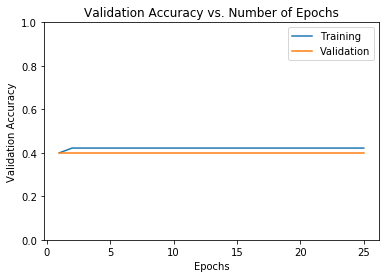

In [174]:
# Accuracy
num_epochs = 25
thist = []
vhist = []
thist = np.array([h.cpu().numpy() for h in train_acc])
vhist = np.array([h.cpu().numpy() for h in val_acc])

plt.title("Validation Accuracy vs. Number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()
plt.show()

### Confusion matrix

In [175]:
# Source: @ptrblck at Pytorch forum
nb_classes = 4

cm = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for cow, sample in dataloaders['val']:
        inputs = sample['seq'].view(batch_size, 20, 50)
        inputs = inputs.float().to(device)
        labels = sample['label'].to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        print(cow)
        print('True: ', labels)
        print('Pred: ', preds)
        print()
        for t, p in zip(labels.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1
                               
print(cm)

('cow234-3', 'cow257-4', 'cow1404-0', 'cow160-7', 'cow276-1', 'cow56-7', 'cow210-2', 'cow56-14', 'cow248-14', 'cow274-3', 'cow80-0', 'cow224-1', 'cow278-2', 'cow285-4', 'cow1403-4', 'cow267-3')
True:  tensor([1, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 0, 0, 3, 0], device='cuda:0')
Pred:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

('cow202-5', 'cow273-1', 'cow253-6', 'cow240-3', 'cow69-1', 'cow210-4', 'cow243-1', 'cow208-1', 'cow285-6', 'cow267-4', 'cow215-7', 'cow285-7', 'cow272-7', 'cow274-7', 'cow234-1', 'cow160-6')
True:  tensor([3, 0, 1, 0, 3, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1, 1], device='cuda:0')
Pred:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

('cow273-14', 'cow202-0', 'cow262-4', 'cow234-2', 'cow287-7', 'cow161-14', 'cow240-4', 'cow216-5', 'cow272-4', 'cow253-0', 'cow212-14', 'cow212-6', 'cow233-5', 'cow217-2', 'cow155-1', 'cow215-4')
True:  tensor([1, 3, 1, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 0, 1, 2], device='cuda:0')
Pred:  tens

/home/wei-chan.hsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
